In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


ST2="data3/PAT_ph_compare_results.tsv"

PALETTE_PARAMS='Accent'
PALETTE='Set2'

In [58]:
ct_name = "Total"  #'Знач. наб. SNP' # clumps total
cc_name = "Precision"  #'СС (Доля наборов, содержащих причинные SNP)'
sf_name = "Recall"  #'SF (Доля найденных причинных SNP)'

column_names = {
    "ms": "md_beta / sd_beta",
    "m_beta": "effect size (m_beta)",
    "sd_beta": "standard deviation of effect size (sd_beta)",
    "gen_var": "genetic effects variance (gen_var)",
    "h2s": "proportion of the genetic variant effect variance (h2s)",  # should be 1, we don't have background noise in genetic components
    "theta": "proportion of variance\nof shared genetic variant effects (theta)",
    "pIndep": "proportion of genetic variant effects\nto have a trait-independent fixed effect (pIndependent)",
    "phi": "proportion of observational noise effect variance (phi)",
    "alpha": "variance of shared observational noise effect (alpha)",
    "K": "amount of causal SNPs (K); k=K/2",
}
# m_beta – effect size, sd_beta – standard deviation of effect size, gen_var – наследственная изменчивость, h2s – доля изменчивости, объясняемая причинными SNP.

In [39]:
', '.join(column_names.values())

'effect size (m_beta), standard deviation of effect size (sd_beta), genetic effects variance (gen_var), proportion of the genetic variant effect variance (h2s), proportion of variance\nof shared genetic variant effects (theta), proportion of genetic variant effects\nto have a trait-independent fixed effect (pIndependent), proportion of observational noise effect variance (phi), variance of shared observational noise effect (alpha), amount of causal SNPs (K); k=K/2'

In [40]:
data = pd.read_csv(ST2, sep='\t')
data['params'] = '('+data.m_beta.astype(str) + ", " + data.sd_beta.astype(str) + ", " + data.gen_var.astype(str) + ", " + data.h2s.astype(str) + ")"
data

,K,m_beta,sd_beta,gen_var,h2s,theta,pIndep,phi,alpha,clumps_total,clumps_causal,clumps_not_causal,causal_found,causal_not_found,params
0,10,0.05,0.001,0.0,1.0,0.0,1.0,1,0.0,1,0.00000,1.00000,0.00000,1.00000,"(0.05, 0.001, 0.0, 1.0)"
1,30,0.05,0.001,0.0,1.0,0.0,1.0,1,0.0,1,0.00000,1.00000,0.00000,1.00000,"(0.05, 0.001, 0.0, 1.0)"
2,10,0.05,0.001,0.0,1.0,0.0,1.0,1,0.5,0,0.00000,0.00000,0.00000,1.00000,"(0.05, 0.001, 0.0, 1.0)"
3,30,0.05,0.001,0.0,1.0,0.0,1.0,1,0.5,0,0.00000,0.00000,0.00000,1.00000,"(0.05, 0.001, 0.0, 1.0)"
4,10,0.05,0.001,0.0,1.0,0.5,0.5,1,0.0,1,0.00000,1.00000,0.00000,1.00000,"(0.05, 0.001, 0.0, 1.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,30,0.50,0.200,1.0,1.0,0.5,0.5,1,0.5,63,0.39683,0.60317,0.83333,0.16667,"(0.5, 0.2, 1.0, 1.0)"
236,10,0.50,0.200,1.0,1.0,1.0,0.0,1,0.0,45,0.22222,0.77778,1.00000,0.00000,"(0.5, 0.2, 1.0, 1.0)"
237,30,0.50,0.200,1.0,1.0,1.0,0.0,1,0.0,63,0.39683,0.60317,0.83333,0.16667,"(0.5, 0.2, 1.0, 1.0)"
238,10,0.50,0.200,1.0,1.0,1.0,0.0,1,0.5,45,0.22222,0.77778,1.00000,0.00000,"(0.5, 0.2, 1.0, 1.0)"


## Clumps causal - causal found

Let: Clumps causal = CC, Causal found = SF

In [43]:
d = data.rename(columns={'clumps_causal':"CC", "causal_found": "SF", 'clumps_total': ct_name})
d['F1'] = 2/(1/d.CC+1/d.SF)
# d = d[d.clumps_total != 0]

darr = d.copy(deep=True)[((d.SF>1.0) & (d.CC>1.0))]
# darr = d.copy(deep=True)
# darr = darr[((d.SF>0.9) & (d.CC>0.4)) |
#  ((d.SF>0.75) & (d.CC>0.6))  |
#  ((d.SF>0.7) & (d.CC>0.75))  |
#  ((d.SF>0.5) & (d.CC>0.9))  |
#  ((d.SF>0.4) & (d.CC>0.95))  ]
darr['x']=0
darr['y']=0
darr

,K,m_beta,sd_beta,gen_var,h2s,theta,pIndep,phi,alpha,Total,CC,clumps_not_causal,SF,causal_not_found,params,F1,x,y


In [46]:
## # manual setting
# darr.loc[139,'y']=0.025
# darr.loc[139,'x']=-0.015
# darr.loc[111,'y']=0.02
# darr.loc[147,'y']=-0.003
# darr.loc[0,'y']=-0.025
# darr.loc[104,'y']=-0.03
# darr.loc[104,'x']=-0.01
darr.sort_values(by=['CC', 'SF'], ascending=[False, False], inplace=True)
darr

,K,m_beta,sd_beta,gen_var,h2s,theta,pIndep,phi,alpha,Total,CC,clumps_not_causal,SF,causal_not_found,params,F1,x,y


In [47]:
darr

,K,m_beta,sd_beta,gen_var,h2s,theta,pIndep,phi,alpha,Total,CC,clumps_not_causal,SF,causal_not_found,params,F1,x,y


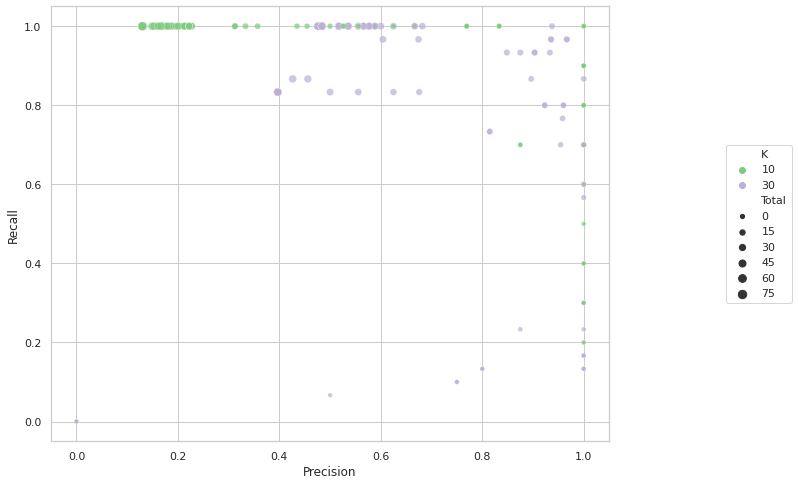

In [48]:
sns.set()
plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(d, 
                     x='CC', 
                     y='SF', 
                     hue='K', 
                     size=ct_name, 
                     palette=PALETTE_PARAMS,  
                     alpha=.7,)
ax.set(xlabel=cc_name, ylabel=sf_name)

plt.plot([], [], ' ')

for key, value in darr.iterrows():
    ax.text(value['CC']+0.01+value['x'], 
            value['SF']+value['y'], 
            value['params'], 
            horizontalalignment='left', 
            size='medium', 
            color='black')

plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.savefig('images/SF4.1.pdf')
plt.show()

## Params -- CC/SF

In [59]:
def draw_violins(d, cur_y, cur_name, columns, name = '', min_y=-0.05, max_y=1.05):
    sns.set(rc={"figure.figsize": (15, 10)})
    sns.set_theme(style="whitegrid")
    # get legend
    ax = sns.violinplot(d, 
                        x=columns[0], #!!!!!!!!!!!!!!!!!!!!! эт че
                        y=cur_y, 
                        palette=PALETTE_PARAMS,
                        hue='K')
    handles, labels = ax.get_legend_handles_labels()
    plt.clf()
    # draw
    fig, axs = plt.subplots(nrows=2, ncols=2)
    for i, c in enumerate(columns):
        row = i // 2
        col = i % 2
        ax = sns.stripplot(d, 
                            x=c, 
                            y=cur_y, 
                            hue='K', 
                            palette=PALETTE_PARAMS,
                            alpha=.7,
                            ax=axs[row][col], 
                            legend=False, 
                           dodge=True
                           )
        
        ax = sns.violinplot(d, 
                            x=c, 
                            y=cur_y, 
                            hue='K', 
                            palette=PALETTE_PARAMS,
                            alpha=.7,
                            ax=axs[row][col], 
                            legend=False, 
                            cut=0
                           )
        plt.setp(ax.collections, alpha=.58)
        ax.legend_.remove()
        ax.set(ylabel='', xlabel=column_names[c])
        ax.set(ylim=(min_y, max_y))
        ax
    fig.supylabel(cur_name, y=0.5, x=0.07)
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.9, 0.5), title=column_names['K'])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    if name != '':
        plt.savefig(name)
    plt.show()

In [60]:
# d[['gen_var', 'CC', 'SF', 'K']].groupby(['gen_var', 'K']).agg(['mean', 'std'])

In [67]:
columnses = [["m_beta", "sd_beta", "gen_var", "h2s"], 
            ["theta","pIndep","phi","alpha"]]

In [68]:
d['ms']=d['sd_beta']/d['m_beta']

<Figure size 1080x720 with 0 Axes>

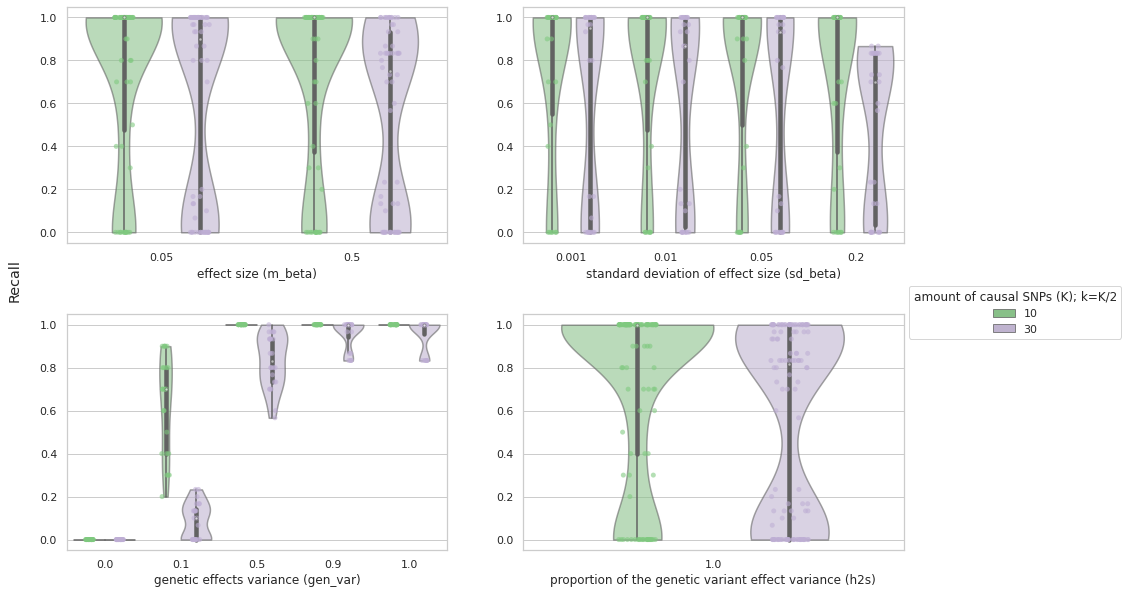

<Figure size 1080x720 with 0 Axes>

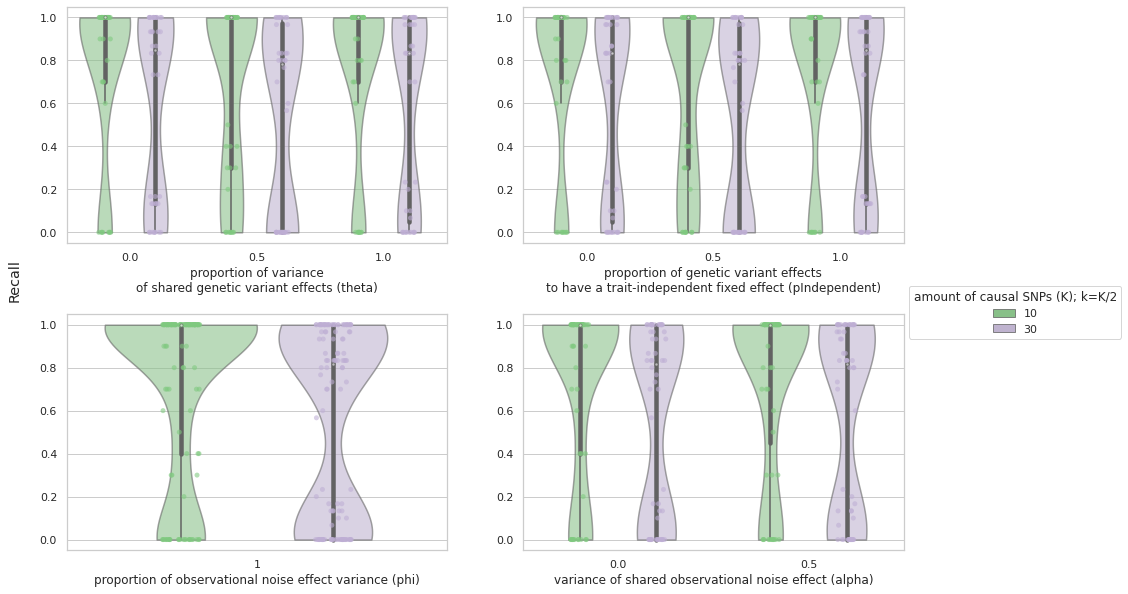

<Figure size 1080x720 with 0 Axes>

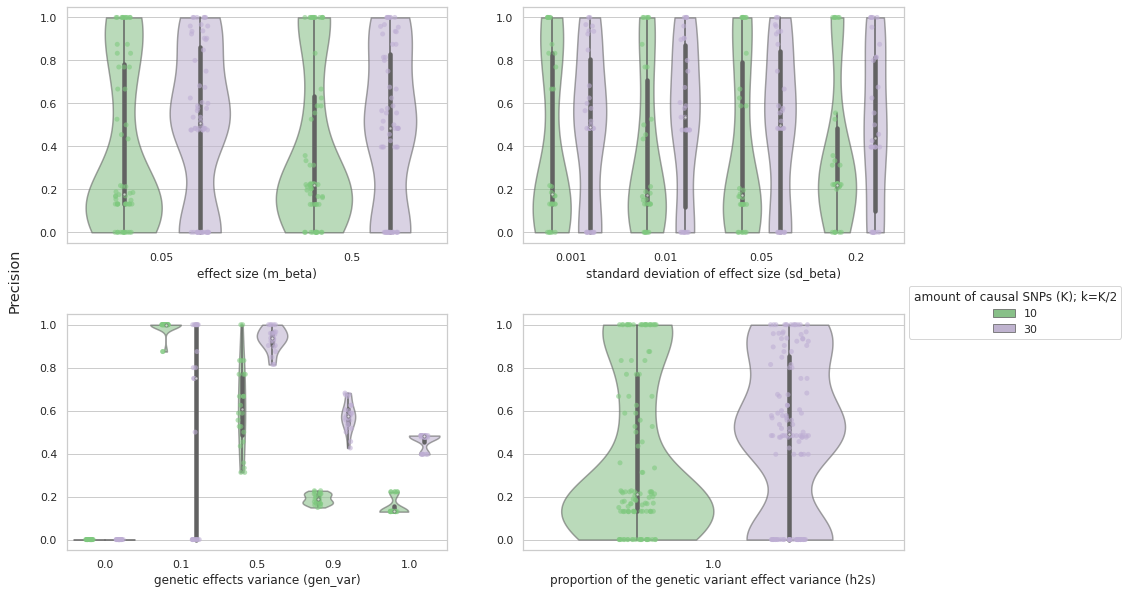

<Figure size 1080x720 with 0 Axes>

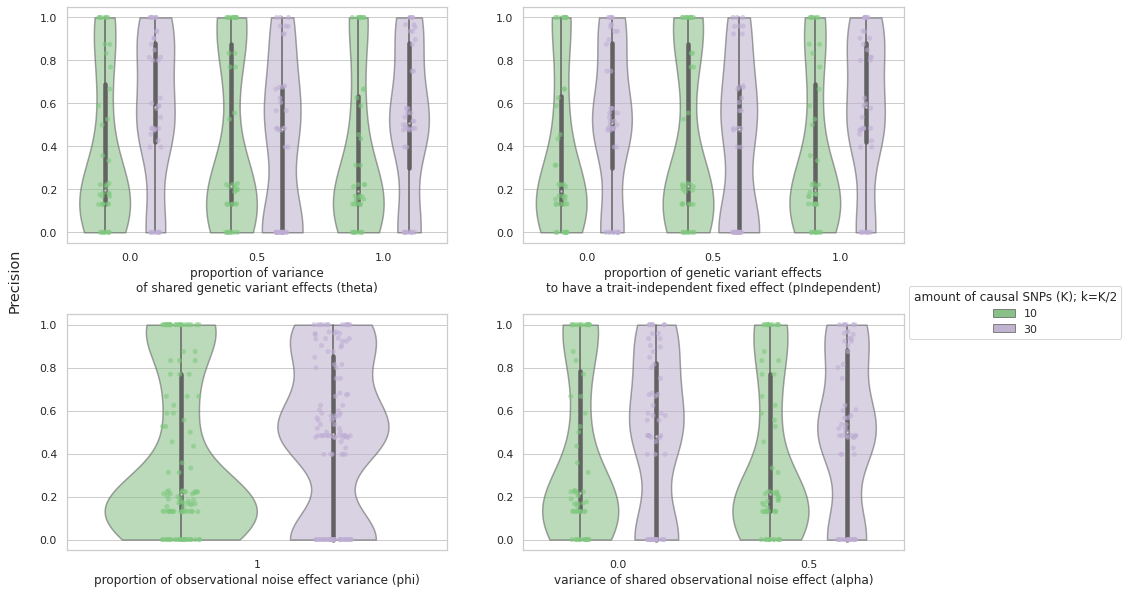

<Figure size 1080x720 with 0 Axes>

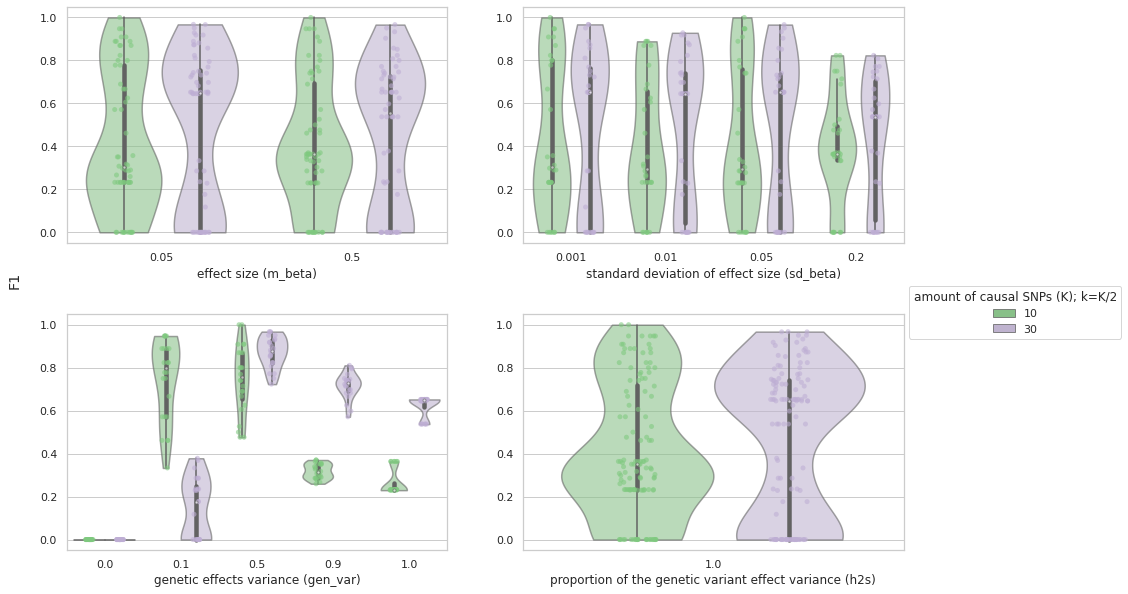

<Figure size 1080x720 with 0 Axes>

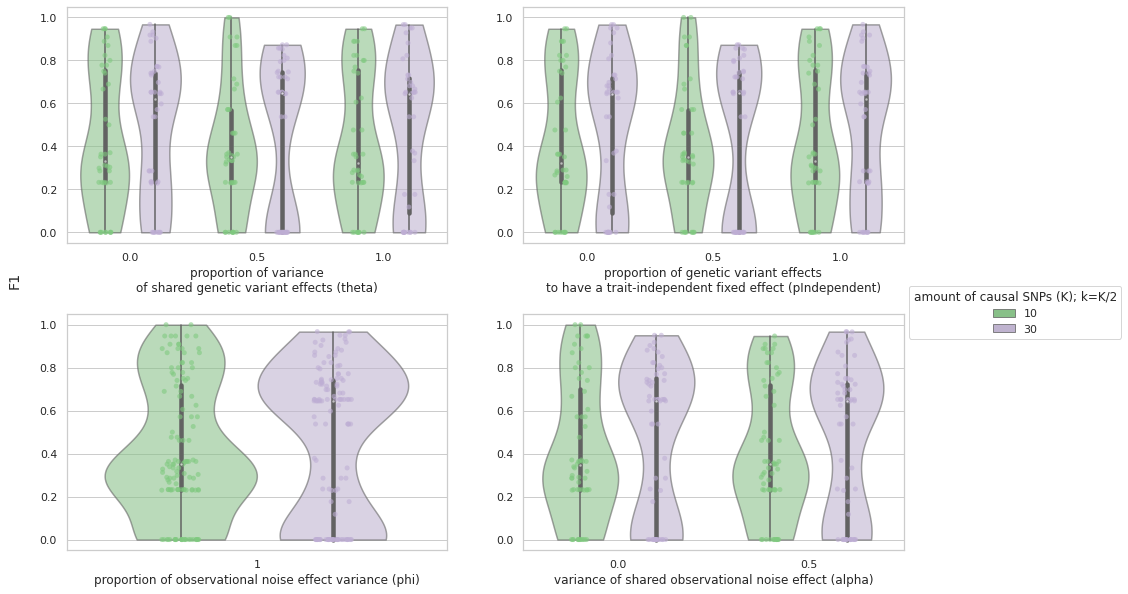

In [69]:
cur_ys = ['SF', 'CC', 'F1']
cur_names = [sf_name, cc_name, 'F1']

i=1
for cur_y, cur_name in zip(cur_ys, cur_names):
    for columns in columnses:
        name=f'images/SF3.{i}.pdf'
        i+=1
        draw_violins(d, cur_y, cur_name, columns, name=name)